# Assignment 3

In [2]:
# Scientific and vector computation for python
import numpy as np

# Data Manipulation Library
import pandas as pd

# Plotting library
from matplotlib import pyplot

# inline graphs
%matplotlib inline

# Optimization module in scipy
from scipy import optimize

# import KFold library for splitting dataset
from sklearn.model_selection import KFold

# data url
github_url = 'https://raw.githubusercontent.com/RohanK99/machine-learning/master/CS480/A3/nonlinear-regression-dataset/'

In [12]:
# read training data
training_data = []
training_labels = []
for i in range(10):
    # training data
    url = github_url + 'trainInput{}.csv'.format(i+1)
    data = pd.read_csv(url, header=None)
    training_data.append(data)
    # training labels
    url = github_url + 'trainTarget{}.csv'.format(i+1)
    data = pd.read_csv(url, header=None)
    training_labels.append(data)

# concatenate data into 1 large data set and convert to numpy
X = (pd.concat(training_data)).to_numpy()
X = np.c_[np.ones(X.shape[0]), X] # add column of ones
y = ((pd.concat(training_labels)).to_numpy())[:,0] # first column

In [4]:
# read test data
data_url = github_url + 'testInput.csv'
label_url = github_url + 'testTarget.csv'
data = pd.read_csv(data_url, header=None)
t_X = data.to_numpy()
t_X = np.c_[np.ones(t_X.shape[0]), t_X] # add column of ones
labels = pd.read_csv(label_url, header=None)
t_y = labels.to_numpy()[:,0]

## Question 1
a) Regularized generalized linear regression: perform least square regression with the penalty term $0.5w^Tw$. Use monomial basis functions up to degree $d: \{\prod_{i}(x_i)^{n_i} | \sum_{i}n_i \leq d\}$. A monomial of degree less than or equal to $d$ is a product of variables (e.g. $\prod_{i}(x_i)^{n_i}$) where the sum of their exponents is less than or equal to $d$ (e.g. $\sum_{i}n_i \leq d\$)

Recall that the linear regression model can be expressed with hypothesis:

$$ h_w(x) = w^Tx = w_0 + w_1 x_1 $$

where the minimization problem is

$$ w^* = argmin_w \frac{1}{2}\sum_{n=1}^{N} (t_n - w^T \overline{x}_n)^2 + \frac{\lambda}{2}|w|_2^2$$

Now for non-linear data we need a generalized linear regression minimization problem. To convert a non-linear problem into a linear one we can apply a basis function to $\overline{x}$. A basis function is a mapping from one vector space to another in which the data is linear.

The polynomial basis function that will be used in the question is $\phi_{j}(x) = x^j$

The hypothesis can now be expressed as
$$ h_w(x) = w_0\phi_0(x) + w_1\phi_1(x) + w_2\phi_2(x) $$

For 2 features our hypothesis up to degree $3$ will look like

$$ h_w(x) = w_0 + w_1x_1 + w_2x_2 + w_3x_1^2 + w_4x_2^2 + w_5x_1^2x_2 + w_6x_1x_2^2 + w_7x_1^2x_2^2 + w_8x_1^3 + w_9x_2^3 $$

We can now extrapolate this hypothesis for any degree $d$.

Applying this to get a genearlized equation for linear regression we get:

$$ w^* = argmin_w \frac{1}{2}\sum_{n=1}^{N} (t_n - w^T \phi(\overline{x}_n))^2 + \frac{\lambda}{2}|w|_2^2$$

Solving for the closed form solution we get.

$$ w^* = (B^TB + \lambda I)^{-1} B^Ty $$

where $B$ is the data after that basis function is applied to $X$.

Note: For this problem we assume $\lambda = 1$

In [18]:
def linear_regression(X, y, lambda_):
  # using regularized closed form solution to return theta (weights)
  # theta = inverse(Lambda*IdentityMatrix+X'*X)*X'*y
  A = np.transpose(X)@X
  b = np.transpose(X)@y
  weights = np.linalg.pinv(lambda_ * np.eye(A.shape[0]) + A)@b
  return weights

In [15]:
def mean_squared_error(X, y, weights):
    predicted = X@weights
    squared_error = np.square(predicted - y)
    return np.mean(squared_error)

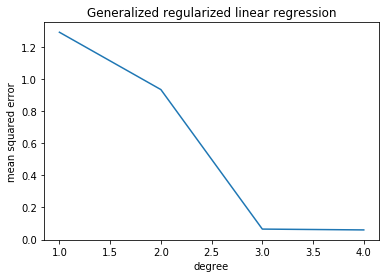

In [19]:
kf = KFold(n_splits=10)
max_degree = 5
lambda_ = 1

mean_squared_errors = [0] * max_degree
for train, test in kf.split(X):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]

    # degree 1
    weights = linear_regression(X_train, y_train, lambda_)
    mean_squared_errors[1] += mean_squared_error(X_test, y_test, weights)

    for d in range(2, max_degree): # degree 2 to 4
        for j in range(d+1): # monomial basis function is applied
            X_train = np.append(X_train, ((X[train][:,1] ** (j)) * (X[train][:,2] ** (d-j))).reshape(X[train].shape[0], 1), axis=1)
            X_test = np.append(X_test, ((X[test][:,1] ** (j)) * (X[test][:,2] ** (d-j))).reshape(X[test].shape[0], 1), axis=1)

        weights = linear_regression(X_train, y_train, lambda_)
        mean_squared_errors[d] += mean_squared_error(X_test, y_test, weights)

mean_squared_errors = [error / 10 for error in mean_squared_errors] # divide by 10 since 10-fold cross validation

pyplot.plot(range(1,max_degree), mean_squared_errors[1:], '-')
pyplot.xlabel("degree")
pyplot.ylabel("mean squared error")
pyplot.title("Generalized regularized linear regression")
pyplot.show()

From this we see that degree 3 provides us the most minimized error and we can apply this to our test dataset

In [24]:
X_train = X
X_test = t_X

# dataset into monomial of degree 3
for d in range(2, 4):
    for j in range(d+1):
        X_train = np.append(X_train, ((X_train[:,1] ** (j)) * (X_train[:,2] ** (d-j))).reshape(X_train.shape[0], 1), axis=1)
        X_test = np.append(X_test, ((X_test[:,1] ** (j)) * (X_test[:,2] ** (d-j))).reshape(X_test.shape[0], 1), axis=1)

weights = linear_regression(X_train, y, 1)

print("Test set mean squared error: " + str(mean_squared_error(X_test, t_y, weights)))

Test set mean squared error: 0.06366132035168122
